In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import plot_model

In [31]:
temp = pd.read_csv("obesity.csv")
columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
for c in columns:
  dummies = pd.get_dummies(temp[c], prefix=(str(c)+"_"))
  temp = pd.concat([temp, dummies], axis=1)
temp = temp.drop(columns=columns)


d = ['Insufficient_Weight',
       'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I',
       'Obesity_Type_II', 'Obesity_Type_III']
ordinal_encoder = OrdinalEncoder(categories=[d])
temp['NObeyesdad'] = ordinal_encoder.fit_transform(temp[['NObeyesdad']])
y_xgb = temp['NObeyesdad']

temp = temp.drop('NObeyesdad', axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(temp)
X = pd.DataFrame(data = X_rescaled, columns = temp.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y_xgb, test_size=0.2, random_state=15)
X_test_val, X_val, y_test_val, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=15)
eval_set = [(X_train, y_train), (X_val, y_val)]

In [32]:
trial = XGBClassifier(objective='multi:softprob',eval_metric=["merror"])
trial.fit(X_train, y_train, eval_set=eval_set, verbose=True)
y_pred = trial.predict(X_test_val)
print(" Test Accuracy: ", accuracy_score(y_test_val, y_pred))
y_train_pred = trial.predict(X_train)
print(" Train Accuracy: ", accuracy_score(y_train, y_train_pred))


[0]	validation_0-merror:0.07168	validation_1-merror:0.12736
[1]	validation_0-merror:0.05273	validation_1-merror:0.09434
[2]	validation_0-merror:0.04384	validation_1-merror:0.08019
[3]	validation_0-merror:0.03614	validation_1-merror:0.07547
[4]	validation_0-merror:0.02903	validation_1-merror:0.07075
[5]	validation_0-merror:0.02488	validation_1-merror:0.07075
[6]	validation_0-merror:0.02073	validation_1-merror:0.08019
[7]	validation_0-merror:0.01422	validation_1-merror:0.06604
[8]	validation_0-merror:0.01244	validation_1-merror:0.06132
[9]	validation_0-merror:0.01066	validation_1-merror:0.06132
[10]	validation_0-merror:0.01007	validation_1-merror:0.05660
[11]	validation_0-merror:0.00711	validation_1-merror:0.04717
[12]	validation_0-merror:0.00415	validation_1-merror:0.03774
[13]	validation_0-merror:0.00178	validation_1-merror:0.03302
[14]	validation_0-merror:0.00118	validation_1-merror:0.03302
[15]	validation_0-merror:0.00118	validation_1-merror:0.02830
[16]	validation_0-merror:0.00118	v

The test accuracy here is really high at 97.16% so we should look for any overfitting, because this model seems to be great at first glance.

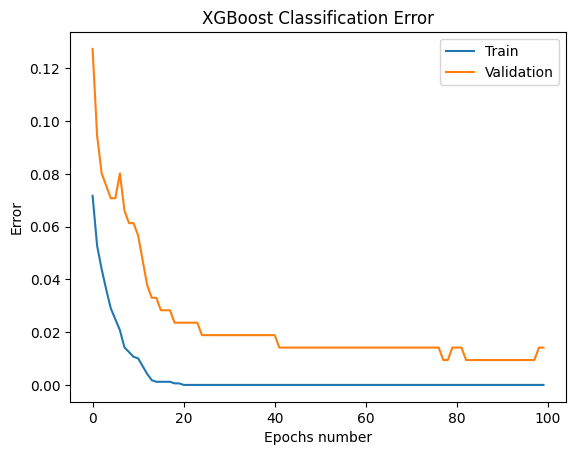

In [39]:
res = trial.evals_result()
epochs = len(res['validation_0']['merror'])
x = range(0, epochs)
plt.plot(x, res['validation_0']['merror'], label='Train')
plt.plot(x, res['validation_1']['merror'], label='Validation')
plt.legend()
plt.ylabel('Error')
plt.title('XGBoost Classification Error')
plt.xlabel('Epochs number')
plt.show()

After plotting the error term for each epoch for both the train and test set as our validation data, we can see that after the range of 20 and 40 epochs, the model doesn't make any big improvements. Therefore, we created an early stopping model that tries to stop the model after 40 epochs, so no overfitting happens since past 40 epochs the model doesn't improve.

In [34]:
earlystopxgb = XGBClassifier(objective='multi:softprob', num_class=7,eval_metric=['merror'], early_stopping_rounds=3)
earlystopxgb.fit(X_train, y_train, eval_set=[(X_val, y_val)])

y_pred = earlystopxgb.predict(X_test_val)

print("Test Accuracy:", accuracy_score(y_test_val, y_pred))
print("Test Precision:", precision_score(y_test_val, y_pred, average='weighted'))
print("Test Recall:", recall_score(y_test_val, y_pred, average='weighted'))

[0]	validation_0-merror:0.12736
[1]	validation_0-merror:0.09434
[2]	validation_0-merror:0.08019
[3]	validation_0-merror:0.07547
[4]	validation_0-merror:0.07075
[5]	validation_0-merror:0.07075
[6]	validation_0-merror:0.08019
[7]	validation_0-merror:0.06604
[8]	validation_0-merror:0.06132
[9]	validation_0-merror:0.06132
[10]	validation_0-merror:0.05660
[11]	validation_0-merror:0.04717
[12]	validation_0-merror:0.03774
[13]	validation_0-merror:0.03302
[14]	validation_0-merror:0.03302
[15]	validation_0-merror:0.02830
[16]	validation_0-merror:0.02830
[17]	validation_0-merror:0.02830
[18]	validation_0-merror:0.02358
[19]	validation_0-merror:0.02358
[20]	validation_0-merror:0.02358
Test Accuracy: 0.976303317535545
Test Precision: 0.9763070561388675
Test Recall: 0.976303317535545


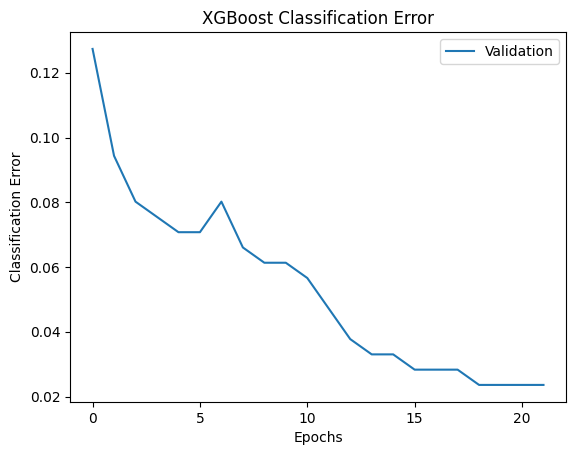

In [35]:
res = earlystopxgb.evals_result()
epochs = len(res['validation_0']['merror'])
x = range(0,  epochs)
plt.plot(x, res['validation_0']['merror'], label='Validation')
plt.legend()
plt.ylabel('Classification Error')
plt.xlabel('Epochs')
plt.title('XGBoost Classification Error')
plt.show()

Now with the use of early-stopping, the test accuracy is 97.63% which is more reasonable and the validation error was low at .02, and the epochs used are a lot less so there is less chances of overfitting. It also stops training at 21 epochs which is what we wanted (something between 20 and 40)

In [36]:
#XGB Cross Validation - https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
def train_evaluateXGB(model, xtrain, ytrain, xtest, ytest):
  model.fit(xtrain, ytrain, eval_set=[(xtest,ytest)])
  accuracy = model.score(xtest, ytest)
  return accuracy
kFold = StratifiedKFold(n_splits = 10)
i=0
sum=0
for train, test in kFold.split(temp,y_xgb):
  print("Current Iteration:",i)
  modelxgb = None
  modelxgb = earlystopxgb
  acc = train_evaluateXGB(modelxgb,temp.loc[[x for x in train]],y_xgb.loc[[x for x in train]],temp.loc[[x for x in test]],y_xgb.loc[[x for x in test]])
  print("Accuracy for each Fold: ", acc)
  i+=1
  sum += acc

print("Mean accuracy:", (sum/i))
#Mean accuracy: 0.9237950460520432

Current Iteration: 0
[0]	validation_0-merror:0.22642
[1]	validation_0-merror:0.23585
[2]	validation_0-merror:0.22170
[3]	validation_0-merror:0.22642
[4]	validation_0-merror:0.22642
[5]	validation_0-merror:0.21226
[6]	validation_0-merror:0.20283
[7]	validation_0-merror:0.18868
[8]	validation_0-merror:0.18868
[9]	validation_0-merror:0.18868
Accuracy for each Fold:  0.8113207547169812
Current Iteration: 1
[0]	validation_0-merror:0.17536
[1]	validation_0-merror:0.16114
[2]	validation_0-merror:0.13744
[3]	validation_0-merror:0.11848
[4]	validation_0-merror:0.12796
[5]	validation_0-merror:0.11374
[6]	validation_0-merror:0.11374
[7]	validation_0-merror:0.10427
[8]	validation_0-merror:0.09479
[9]	validation_0-merror:0.09005
[10]	validation_0-merror:0.08531
[11]	validation_0-merror:0.09005
[12]	validation_0-merror:0.08531
Accuracy for each Fold:  0.9146919431279621
Current Iteration: 2
[0]	validation_0-merror:0.11848
[1]	validation_0-merror:0.06161
[2]	validation_0-merror:0.04739
[3]	validation

Our cross-validation ran well too giving a mean accuracy of 95.03%, but performs not as well in the first fold. The other folds are all really good though.

In [40]:
import pickle

In [41]:
filename = 'xgb_model.sav'
pickle.dump(earlystopxgb, open(filename, 'wb'))
